In [506]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv

def get_image(path: str):
    #convert("L") - konwersja zdjęcia do skali szarości
    return np.array(Image.open(path).convert("L") )

def show_image(imageArray: np.ndarray):
    img = Image.fromarray(imageArray)
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)  
    plt.show()    

# Zadanie nr 1: Platforma testowa
Napisz skrypt w Pythonie/Matlabie umożliwiający wczytywanie i wizualizację badanych obrazów. Program powinien umożliwiać:
1. wyświetlanie obrazu wczytanego z pliku o podanej nazwie,
2. sporządzenie wykresów zmian poziomu szarości wzdłuż wybranej linii poziomej
lub pionowej o zadanej współrzędnej,
3. wybór podobrazu (prostokątnego obszaru) o podanych współrzędnych oraz jego
zapis do pliku o zadanej nazwie.

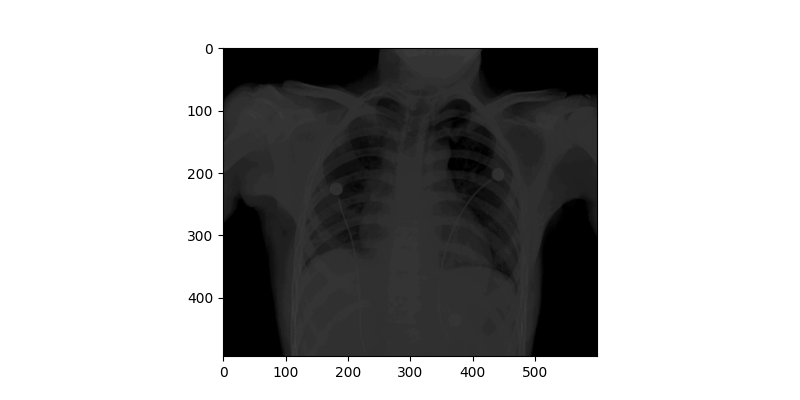

In [507]:
img_chest_xray = get_image('resources/chest-xray.tif')
show_image(img_chest_xray)

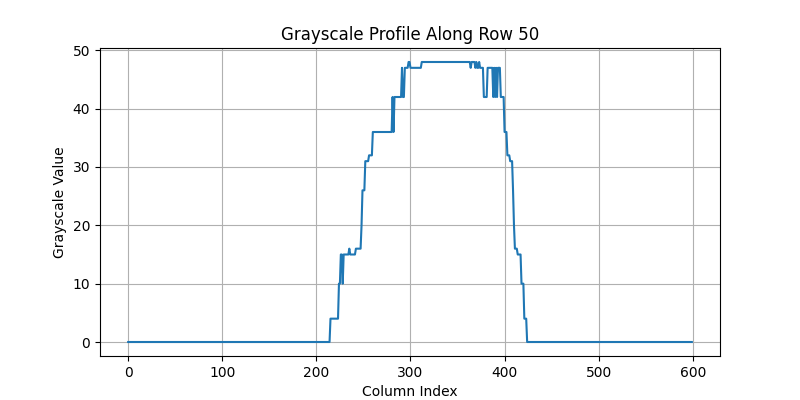

In [508]:
def plot_line_profile(image: np.ndarray, index: int, orientation: str):
    plt.figure(figsize=(8, 4))

    if orientation == 'horizontal':
        line_data = image[index, :]  # Extract the row
        plt.title(f'Grayscale Profile Along Row {index}')
        plt.xlabel('Column Index')
    elif orientation == 'vertical':
        line_data = image[:, index]  # Extract the column
        plt.title(f'Grayscale Profile Along Column {index}')
        plt.xlabel('Row Index')
    else:
        raise ValueError("Orientation must be 'horizontal' or 'vertical'")

    plt.plot(line_data)
    plt.ylabel('Grayscale Value')
    plt.grid(True)
    plt.show()


global img_chest_xray
plot_line_profile(img_chest_xray, 50, 'horizontal')

# Zadanie nr 2: Przekształcenia punktowe
```
Przekształcenie punktowe T obrazu ma ogólną postać s = T(r), gdzie r, s oznaczają odpowiednio poziom szarości piksela obrazu wejściowego i wyjściowego.
```

Zaobserwuj działanie następujących przekształceń punktowych na
przykładowych obrazach:
<br/>
a) Mnożenie obrazu przez stałą T(r) = c · r, gdzie c jest stałą.
Obrazy: chest_xray.tif, pollen-dark.tif, spectrum.tif.
<br/>
b) Transformację logarytmiczną
T(r) = c · log (1 + r).
Obraz: spectrum.tif.
<br/>
c) Zmianę dynamiki skali szarości (kontrastu). Możesz zastosować transformację o
postaci
T(r) = 1/(1 + (m/r)^e),
<br/>
gdzie m i e są ustalonymi parametrami przekształcenia (np. m = 0,45, e = 8).
Wykreśl T(r), by lepiej uwidocznić wpływ T na kontrast obrazu wyjściowego.
Przeprowadź eksperymenty z różnymi wartościami parametrów m i e.
<br/>
d) Korekcję gamma, zdefiniowaną jako s = c · r^γ
, gdzie c > 0 i γ > 0 są stałymi
we wzorze przekształcenia.
Obraz: aerial_view.tif.

In [509]:
def image_transform_iterative(image: np.ndarray, transform: callable):
    copy = image.copy()
    for i in range(copy.shape[0]):
        for j in range(copy.shape[1]):
            copy[i, j] = transform(copy[i, j])
    return copy


def image_transform(image: np.ndarray, transform: callable):
    vfunc = np.vectorize(transform)
    return vfunc(image.copy())


# UWAGA: funkcja transformująca musi przyjmować i zwracać wartości z zakresu [0, 255], jeśli przekroczy 255 to zostanie obcięta
def image_transform_optimized(image: np.ndarray, transform: callable):
    transformed_img = transform(image.copy())
    return np.clip(transformed_img, 0, 255).astype(image.dtype)

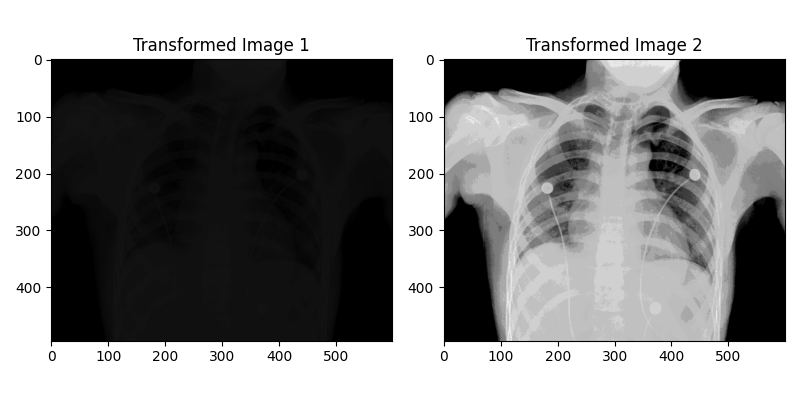

In [510]:
# a) Mnożenie razy stałą
def const_transform1(x): return x*0.35
def const_transform2(x): return x*4


global img_chest_xray
img_chest_xray_transformed1 = image_transform_optimized(
    img_chest_xray, const_transform1)
img_chest_xray_transformed2 = image_transform_optimized(
    img_chest_xray, const_transform2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(Image.fromarray(img_chest_xray_transformed1),
           cmap='gray', vmin=0, vmax=255)
ax1.set_title('Transformed Image 1')
ax2.imshow(Image.fromarray(img_chest_xray_transformed2),
           cmap='gray', vmin=0, vmax=255)
ax2.set_title('Transformed Image 2')
plt.tight_layout()
plt.show()

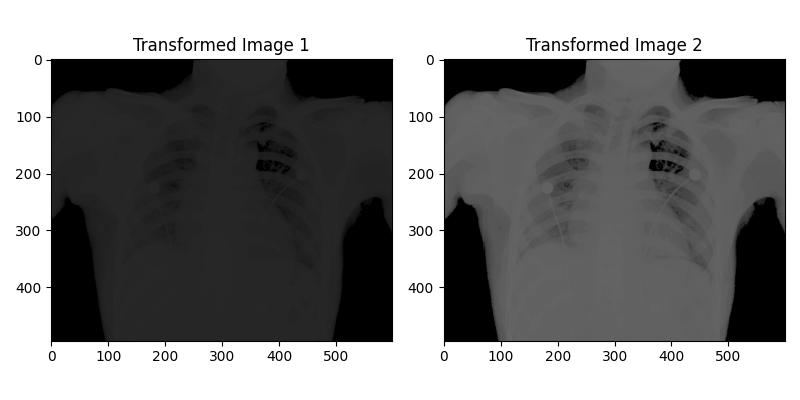

In [511]:
# b) Transformacja logarytmiczna
def logarithmic_transform(x): return 10 * np.log(1 + x)
def logarithmic_transform2(x): return 25 * np.log(1 + x)


global img_chest_xray
img_chest_xray_transformed1 = image_transform_optimized(
    img_chest_xray, logarithmic_transform)
img_chest_xray_transformed2 = image_transform_optimized(
    img_chest_xray, logarithmic_transform2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(Image.fromarray(img_chest_xray_transformed1),
           cmap='gray', vmin=0, vmax=255)
ax1.set_title('Transformed Image 1')
ax2.imshow(Image.fromarray(img_chest_xray_transformed2),
           cmap='gray', vmin=0, vmax=255)
ax2.set_title('Transformed Image 2')
plt.tight_layout()
plt.show()

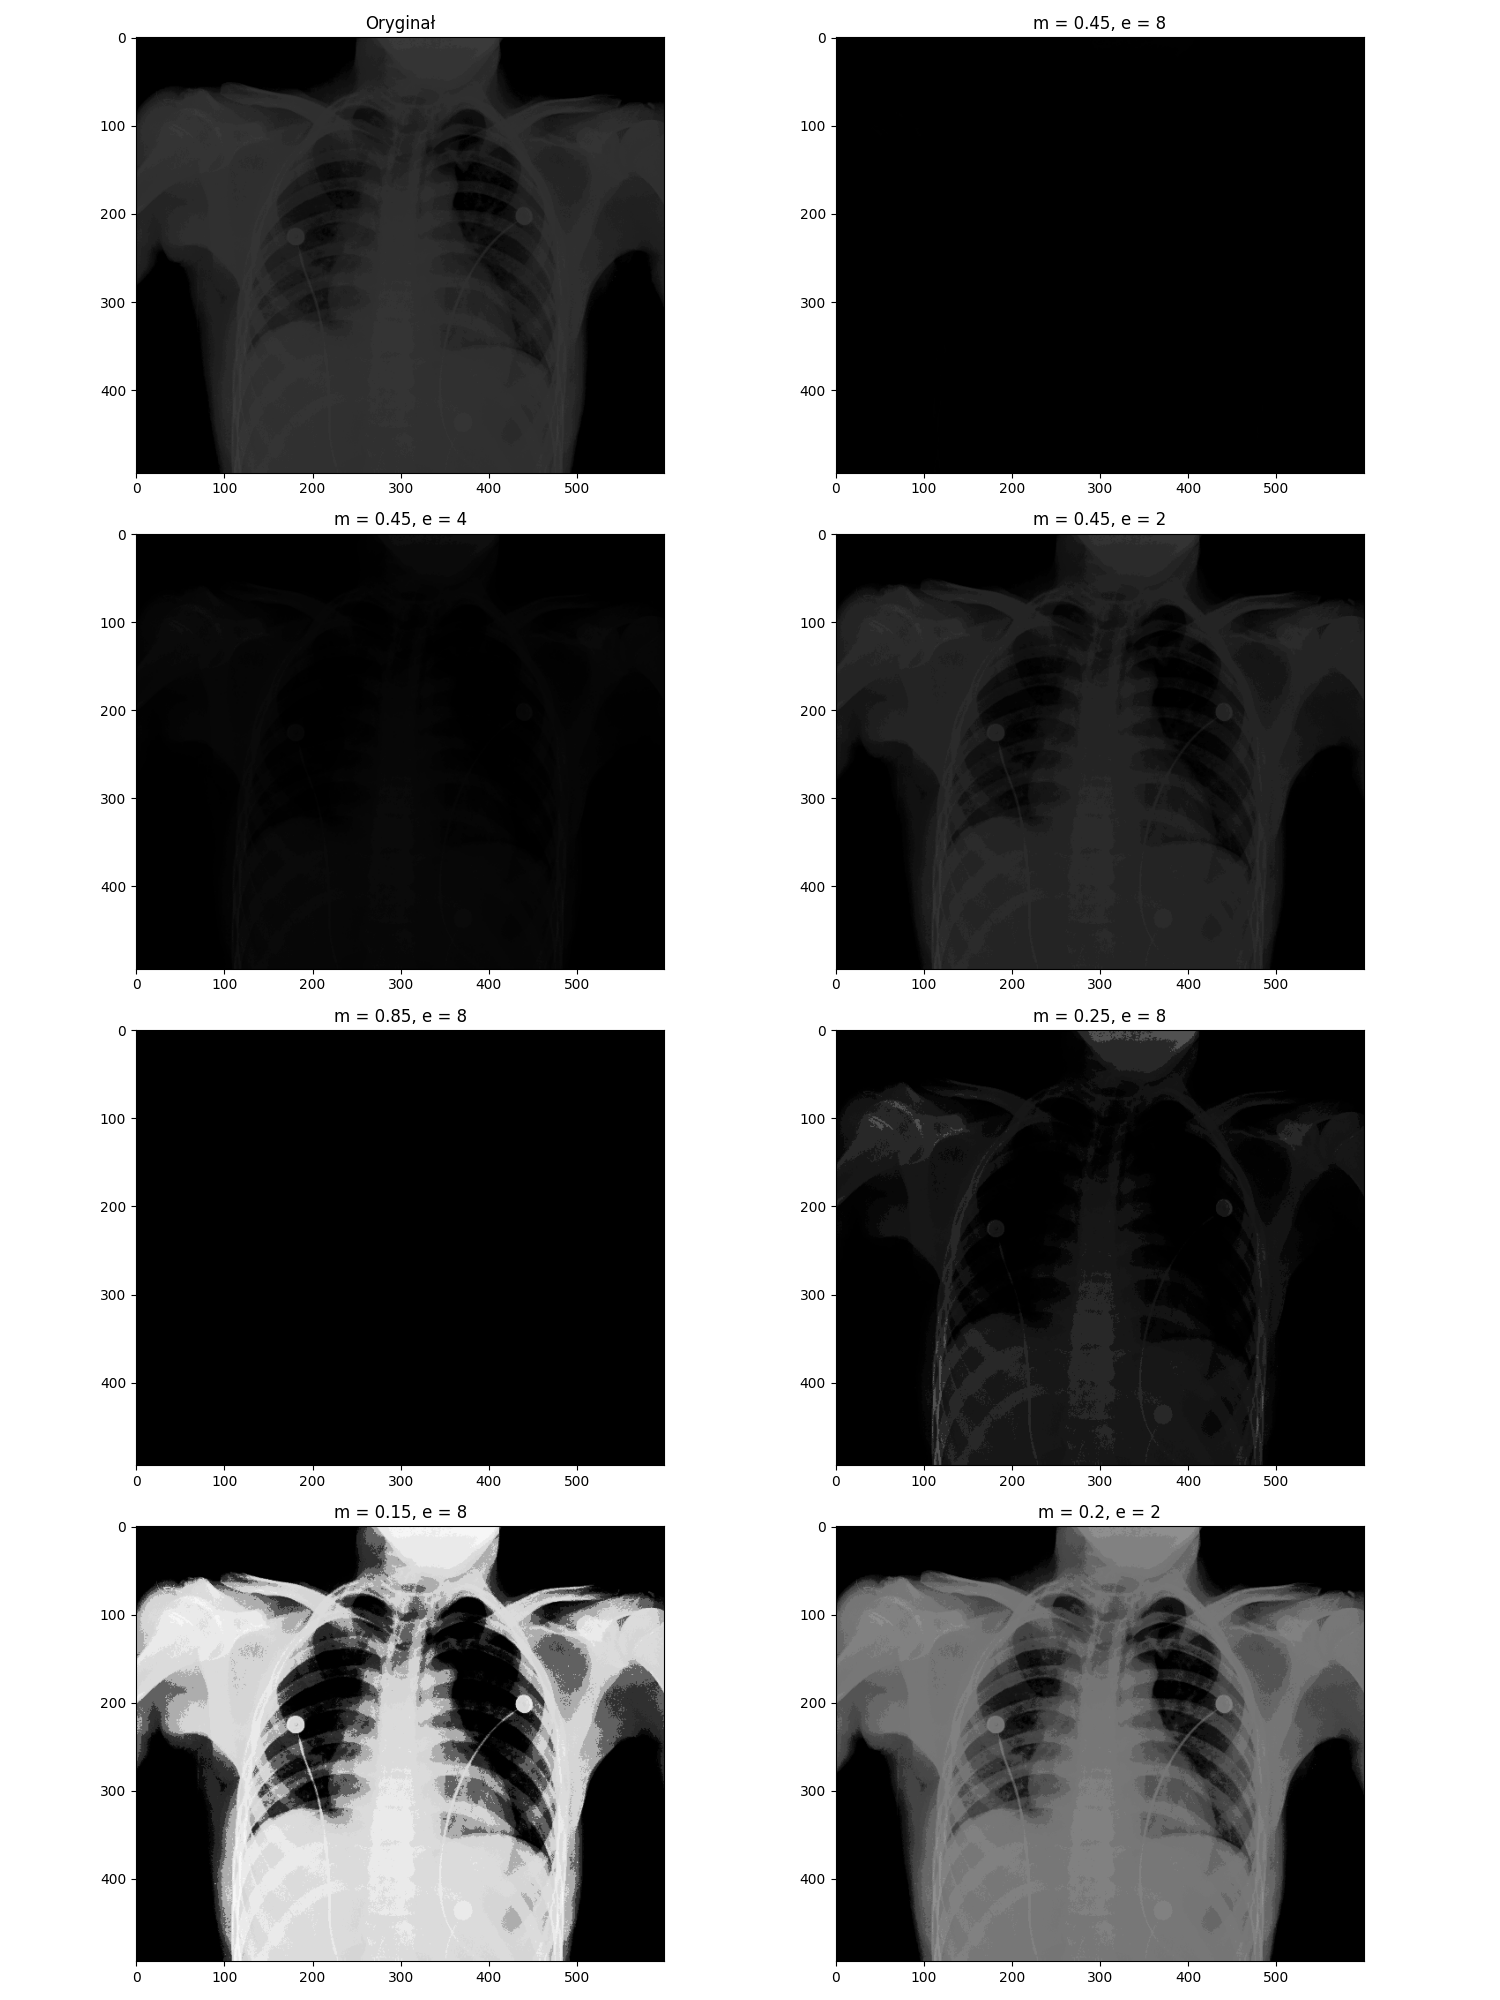

In [512]:
# c) Zmianę dynamiki skali szarości
epsilon = 1e-8


def contrast_stretching_transform(x): return (
    255/(1+np.power(0.45/((x+epsilon)/255.0), 8)))


def contrast_stretching_transform2(
    x): return (255/(1+np.power(0.45/((x+epsilon)/255.0), 4)))


def contrast_stretching_transform3(
    x): return (255/(1+np.power(0.45/((x+epsilon)/255.0), 2)))


def contrast_stretching_transform4(
    x): return (255/(1+np.power(0.85/((x+epsilon)/255.0), 8)))


def contrast_stretching_transform5(
    x): return (255/(1+np.power(0.25/((x+epsilon)/255.0), 8)))


def contrast_stretching_transform6(
    x): return (255/(1+np.power(0.15/((x+epsilon)/255.0), 8)))


def contrast_stretching_transform7(
    x): return (255/(1+np.power(0.2/((x+epsilon)/255.0), 2)))


# def contrast_stretching_transform(
#     x): return (1 / (1 + (0.45/x)**8))
global img_chest_xray

img_chest_xray_transformed1 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform)
img_chest_xray_transformed2 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform2)
img_chest_xray_transformed3 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform3)
img_chest_xray_transformed4 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform4)
img_chest_xray_transformed5 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform5)
img_chest_xray_transformed6 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform6)
img_chest_xray_transformed7 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform7)

plt.figure(figsize=(15, 20))
plt.subplot(4, 2, 1)


plt.subplot(4, 2, 1)
plt.title('Oryginał')
plt.imshow(Image.fromarray(img_chest_xray), cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 2)
plt.title('m = 0.45, e = 8')
plt.imshow(img_chest_xray_transformed1, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 3)
plt.title('m = 0.45, e = 4')
plt.imshow(img_chest_xray_transformed2, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 4)
plt.title('m = 0.45, e = 2')
plt.imshow(img_chest_xray_transformed3, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 5)
plt.title('m = 0.85, e = 8')
plt.imshow(img_chest_xray_transformed4, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 6)
plt.title('m = 0.25, e = 8')
plt.imshow(img_chest_xray_transformed5, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 7)
plt.title('m = 0.15, e = 8')
plt.imshow(img_chest_xray_transformed6, cmap='gray', vmin=0, vmax=255)

plt.subplot(4, 2, 8)
plt.title('m = 0.2, e = 2')
plt.imshow(img_chest_xray_transformed7, cmap='gray', vmin=0, vmax=255)


plt.tight_layout()
plt.show()

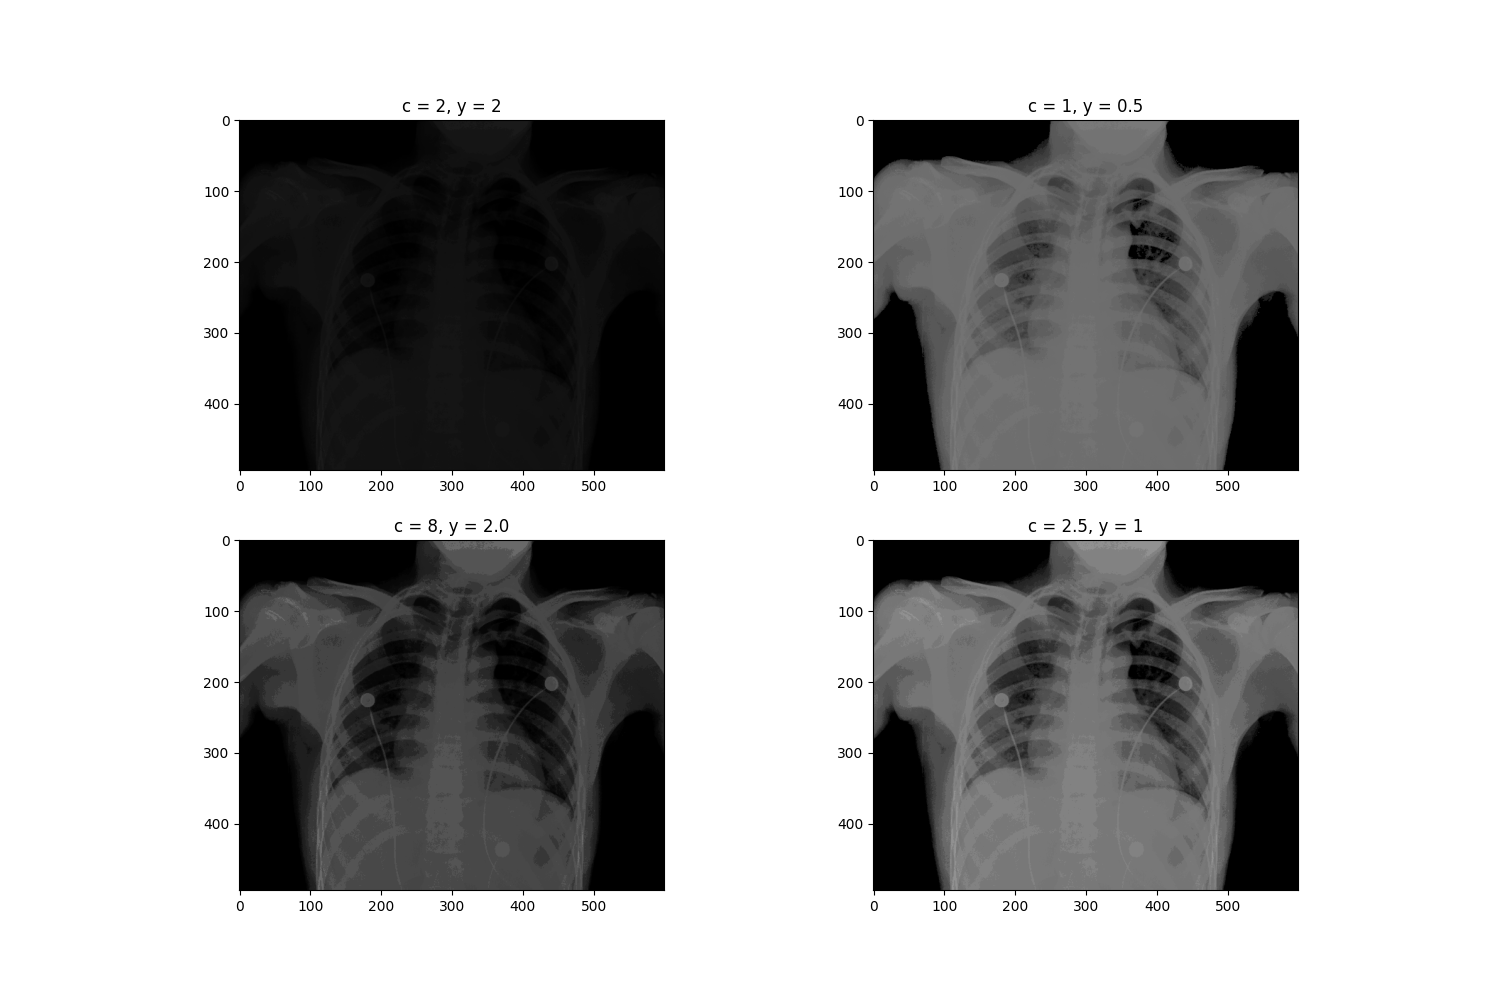

In [513]:
# d) Korekcję gamma
def contrast_stretching_transform(x): return 255*2*np.power(x/255, 2.0)
def contrast_stretching_transform1(x): return 255*np.power(x/255, 0.5)
def contrast_stretching_transform2(x): return 255*8*np.power(x/255, 2.0)
def contrast_stretching_transform3(x): return 255*2.5*np.power(x/255, 1.0)


global img_chest_xray

img_chest_xray_transformed1 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform)
img_chest_xray_transformed2 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform1)
img_chest_xray_transformed3 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform2)
img_chest_xray_transformed4 = image_transform_optimized(
    img_chest_xray, contrast_stretching_transform3)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title('c = 2, y = 2')
plt.imshow(img_chest_xray_transformed1, cmap='gray', vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title('c = 1, y = 0.5')
plt.imshow(img_chest_xray_transformed2, cmap='gray', vmin=0, vmax=255)

plt.subplot(2, 2, 3)
plt.title('c = 8, y = 2.0')
plt.imshow(img_chest_xray_transformed3, cmap='gray', vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title('c = 2.5, y = 1')
plt.imshow(img_chest_xray_transformed4, cmap='gray', vmin=0, vmax=255)

# Zadanie nr 3: Histogram obrazu

Wypróbuj działanie wyrównywania histogramu na przykładowych
obrazach. By zaobserwować skuteczność procedury, poddaj wyrównywaniu obrazy
zbyt ciemne i zbyt jasne. Narysować histogramy obrazów przed i po wyrównaniu.
<br/>
Obrazy: chest_xray.tif, pollen-dark.tif, pollen-ligt.tif,
pollen-lowcontrast.tif, pout.tif, spectrum.tif.

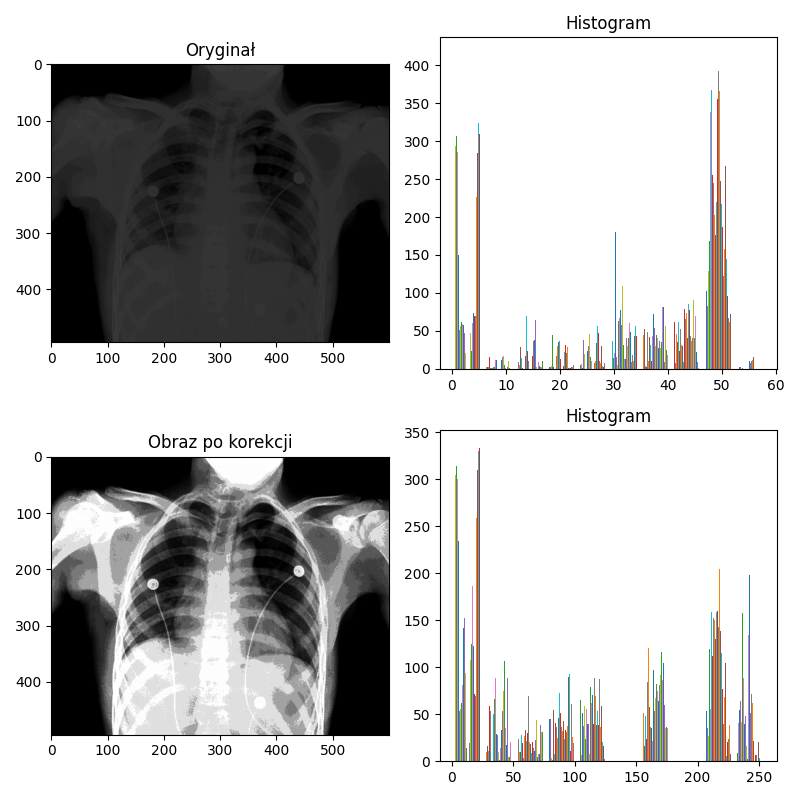

In [514]:
global img_chest_xray


image_correction = cv.equalizeHist(img_chest_xray)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axes

ax1.imshow(Image.fromarray(img_chest_xray),
           cmap='gray', vmin=0, vmax=255)
ax1.set_title('Oryginał')
ax2.hist(img_chest_xray)
ax2.set_title('Histogram')

ax3.imshow(Image.fromarray(image_correction),
           cmap='gray', vmin=0, vmax=255)
ax3.set_title('Obraz po korekcji')
ax4.hist(image_correction)
ax4.set_title('Histogram')
plt.tight_layout()
plt.show()

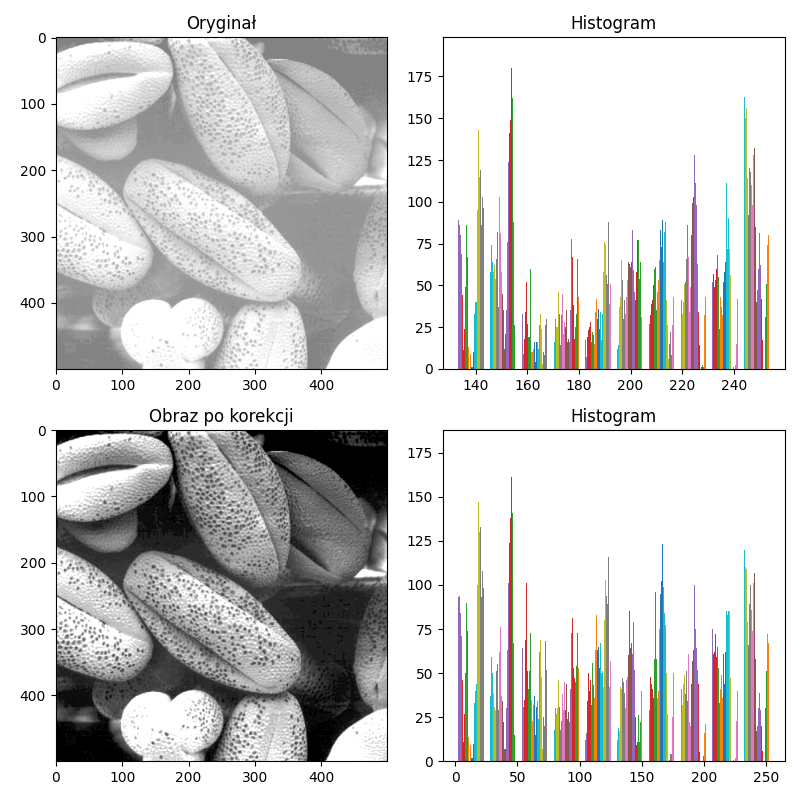

In [515]:
img_pollen_light = get_image('resources/pollen-ligt.tif')

image_correction = cv.equalizeHist(img_pollen_light)


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axes

ax1.imshow(Image.fromarray(img_pollen_light),
           cmap='gray', vmin=0, vmax=255)
ax1.set_title('Oryginał')
ax2.hist(img_pollen_light)
ax2.set_title('Histogram')

ax3.imshow(Image.fromarray(image_correction),
           cmap='gray', vmin=0, vmax=255)
ax3.set_title('Obraz po korekcji')
ax4.hist(image_correction)
ax4.set_title('Histogram')
plt.tight_layout()
plt.show()

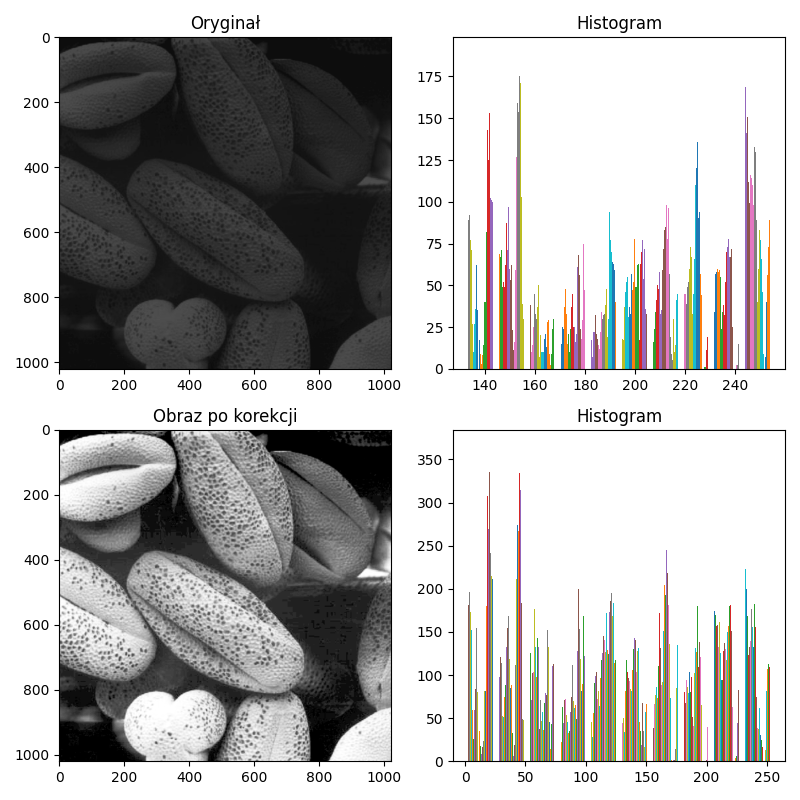

In [516]:
img_pollen_dark = get_image('resources/pollen-dark.tif')

image_correction = cv.equalizeHist(img_pollen_dark)


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axes

ax1.imshow(Image.fromarray(img_pollen_dark),
           cmap='gray', vmin=0, vmax=255)
ax1.set_title('Oryginał')
ax2.hist(img_pollen_light)
ax2.set_title('Histogram')

ax3.imshow(Image.fromarray(image_correction),
           cmap='gray', vmin=0, vmax=255)
ax3.set_title('Obraz po korekcji')
ax4.hist(image_correction)
ax4.set_title('Histogram')
plt.tight_layout()
plt.show()

# Zadanie nr 4: działanie lokalnych kontekstowych
Sprawdź działanie lokalnych kontekstowych omówionych na wykładzie pt. „Transformacje poziomu jasności” jako
a) lokalne wyrównywanie histogramu,
b) poprawa jakości oparta na lokalnych statystykach.
Wykonaj eksperymenty dla różnych rozmiarów masek.